In [28]:
%config IPCompleter.greedy=True

# Reconocimiento de dígitos con KNN

Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [29]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 7.4.0
-- The CXX compiler identification is GNU 7.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /usr/bin/python (found version "3.6.9") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.6m.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/zarthaxx/Desktop/metnum-tp2
-- Configuring done
-- Generating done
-- Build files have

In [140]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum


/home/zarthaxx/Desktop/metnum-tp2/notebooks
Python 3.6.9


## Explorando los datos

In [141]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_train = pd.read_csv("../data/train.csv")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Es un csv, con columnas por cada pixel

### Reducir el dataset

Ya que el dataset es grande, me quedo con una porción de éste

**<font color=red>ESTO ES SOLO PARA HACER PRUEBAS. CUANDO REPORTEN LOS RESULTADOS, USAR DATASET COMPLETO</font>**

In [142]:
df_train = df_train[:5000]

En el primer caracter está el dígito a reconocer. Llamamos a esto `y_train`

In [143]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((5000, 784), (5000, 1))

Convierto el resto a matrices de 28 x 28

A ver cómo se ven...

Supuestamente es un 7


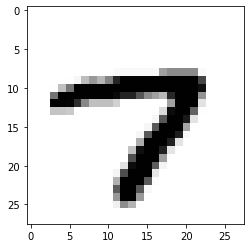

In [144]:
import matplotlib.pyplot as plt

num = 1917

print(f"Supuestamente es un {int(y[num])}")

img = X[num].reshape(28, 28)
plt.imshow(img, cmap="Greys")


### Balance de clases

¿Tenemos la misma cantidad de cada número?

In [145]:
df_train["label"].value_counts(normalize=True)

1    0.1116
2    0.1090
6    0.1032
7    0.1012
0    0.0988
3    0.0960
9    0.0956
8    0.0954
4    0.0954
5    0.0938
Name: label, dtype: float64

No: tenemos más 1 que 5, pero tampoco está tan desbalanceado

## Classifier parameters tunning

### Scoring metrics

Recibo el k de kNN, el dataset de entrenamiento y el de clasificacion, y devuelvo la accuracy del clasificador bajo estos valores

In [146]:
from sklearn.metrics import accuracy_score

def calculate_accuracy(classifier, X_val, y_val) -> float:
    
    y_pred = classifier.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)   
    
    return accuracy

### Cross-validation

In [189]:
import time
import numpy as np
import statistics 

def cross_validate(estimator, X_dataset, y_dataset, scoring, K):
    dict_scores = {}
    dict_scores["score"] = []
    dict_scores["score_time"] = []
    dict_scores["fit_time"] = []
    
    set_size = int( (1.0/K) * X_dataset.shape[0])
    
    for i in range(K):
        l_bound = set_size * i
        r_bound = set_size * (i+1)
        
        start_time = time.time()
        X_train = np.block([[X_dataset[:l_bound]],[X_dataset[r_bound:]]])
        y_train = np.block([[y_dataset[:l_bound]],[y_dataset[r_bound:]]])
        X_val = X_dataset[l_bound:r_bound]
        y_val = y_dataset[l_bound:r_bound]
        
        estimator.fit(X_train, y_train.ravel())
        end_time = time.time()
        fit_time_elapsed = end_time - start_time
          
        start_time = time.time()
        score = scoring(estimator, X_val, y_val)
        end_time = time.time()
        
        score_time_elapsed = end_time - start_time

        dict_scores["score"].append(score)
        dict_scores["score_time"].append(score_time_elapsed)
        dict_scores["fit_time"].append(fit_time_elapsed)
    
    print(dict_scores)
    
    mean_score = statistics.mean(dict_scores["score"])
    
    return mean_score


## Optimization algorithms

### Random search with parameter in range [1,k_max]

 Busco un k al azar en el rango dado


In [167]:
import time
import random

def get_random_k(max_k):
    
    next_k = random.randint(1,max_k)
    
    return next_k

Pruebo al azar distintos k con el objetivo de conseguir algo cercano al k optimo

In [ ]:
def random_search(Classifier, X, y, scoring, k_fold, max_k, max_iterations, time_limit_s):
    
    print("Initiating...")
    
    best_k = 1
    best_score = 0.0
    
    initial_time = time.time()
    
    iterations = 0
    
    print("Starting search...")
    
    while max_iterations > iterations and (time.time() - initial_time) < time_limit_s:
        
        iterations += 1
        
        next_k = get_random_k(max_k)
        
        next_clf = Classifier(next_k)
        
        score = cross_validate(next_clf, X, y, scoring, k_fold) # get initial score
        
        if score > best_score:
            best_k = next_k
            best_score = score  
            
            print(f"{iterations}: Found better solution [k = {best_k}, score: {best_score}]")
        
        if iterations % 1 == 0:
            print("Processing...")
    
    return best_k

### Hill search with parameter in range [1,k_max]

Busco un k "vecino" al mejor k hasta ahora en el rango dado

In [165]:
import time
import random

def get_next_k(actual_k, max_k, change_ratio):
    change_rate = abs(change_ratio) # change_rate should be always possible
    
    min_bound = max(0,actual_k-change_ratio)
    max_bound = min(max_k,actual_k+change_ratio)
    
    next_k = random.randint(min_bound,max_bound)
    
    return next_k

Me muevo por los k cercanos al actual que mejoren el scoring, con la esperanza de encontrar el maximo global o al menos local.

In [165]:
def hill_search(Classifier, X, y, scoring, k_fold, max_k, change_ratio, max_iterations, time_limit_s):
    
    print("Initiating...")
    
    best_k = int((max_k+1)/2)
    best_score = 0 # cross_validate(Classifier(best_k), X, y, scoring, k_fold) # get initial score
    
    initial_time = time.time()
    
    iterations = 0
    
    print("Starting search...")
    
    while max_iterations > iterations and (time.time() - initial_time) < time_limit_s:
        
        iterations += 1
        
        next_k = get_next_k(best_k, max_k, change_ratio)
        
        next_clf = Classifier(next_k)
        
        score = cross_validate(next_clf, X, y, scoring, k_fold) # get initial score
        
        if score > best_score:
            best_k = next_k
            best_score = score  
            
            print(f"{iterations}: Found better solution [k = {best_k}, score: {best_score}]")
        
        if iterations % 1 == 0:
            print("Processing...")
    
    return best_k

### Simulated annealing with parameter in range [1, k_max]

### Conjunto de development

In [150]:
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")


Ahora tengo 4000 instancias de entrenamiento y 1000 de validación


In [176]:
from sklearn.neighbors import KNeighborsClassifier

# Acá pueden cambiar el clasificador nuestro por el de sklearn!

#clf = metnum.KNNClassifier(100)
clf = KNeighborsClassifier(3)

clf.fit(X_train, y_train.ravel())


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [177]:
%%time
acc = calculate_accuracy(clf, X_val, y_val)
print("Accuracy: {}".format(acc))


Accuracy: 0.926
CPU times: user 6.21 s, sys: 16.4 ms, total: 6.22 s
Wall time: 6.33 s


In [170]:
random_search(KNeighborsClassifier, X, y, calculate_accuracy, 5, 1000, 100, 600)

TypeError: random_search() takes 8 positional arguments but 9 were given

In [171]:
hill_search(KNeighborsClassifier, X, y, calculate_accuracy, 5, 1000, 50, 100, 1200)

Initiating...
Starting search...
1: Found better solution [k = 470, score: 0.68775]
Processing...
2: Found better solution [k = 466, score: 0.6895]
Processing...
3: Found better solution [k = 428, score: 0.701]
Processing...
4: Found better solution [k = 413, score: 0.7075]
Processing...
Processing...
6: Found better solution [k = 405, score: 0.7104999999999999]
Processing...
7: Found better solution [k = 367, score: 0.71975]
Processing...
Processing...
9: Found better solution [k = 359, score: 0.72325]
Processing...
10: Found better solution [k = 323, score: 0.73475]
Processing...
Processing...
12: Found better solution [k = 295, score: 0.742]
Processing...
13: Found better solution [k = 254, score: 0.75525]
Processing...
14: Found better solution [k = 211, score: 0.77025]
Processing...
15: Found better solution [k = 193, score: 0.78125]
Processing...
Processing...
Processing...
18: Found better solution [k = 156, score: 0.7977500000000001]
Processing...
19: Found better solution [k =

3

In [190]:
clf2 = KNeighborsClassifier(1)
print(cross_validate(clf2,X,y,calculate_accuracy,5))

{'score': [0.934, 0.92, 0.925, 0.934, 0.93], 'score_time': [6.365467071533203, 6.3872740268707275, 6.4288551807403564, 6.647608757019043, 6.593833923339844], 'fit_time': [0.28504323959350586, 0.27957844734191895, 0.2880568504333496, 0.2830166816711426, 0.28882551193237305]}
0.9286000000000001
